### Set GPU clocks

In [1]:
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

nvidia-persistenced failed to initialize. Check syslog for more details.
Applications clocks set to "(MEM 877, SM 1530)" for GPU 00000000:00:1E.0
All done.


In [2]:
from core import *
from torch_backend import *

### Network definition

In [3]:
def conv_bn(c_in, c_out):
    return {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
        'bn': BatchNorm(c_out), 
        'relu': nn.ReLU(True)
    }

def residual(c):
    return {
        'in': Identity(),
        'res1': conv_bn(c, c),
        'res2': conv_bn(c, c),
        'add': (Add(), ['in', 'res2/relu']),
    }

def net(channels=None, weight=0.125, pool=nn.MaxPool2d(2), extra_layers=(), res_layers=('layer1', 'layer3')):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    n = {
        'input': (None, []),
        'prep': conv_bn(3, channels['prep']),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1']), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2']), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3']), pool=pool),
        'pool': nn.MaxPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'logits': Mul(weight),
    }
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer])
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer])       
    return n

### Download and preprocess data

In [4]:
DATA_DIR = './data'
dataset = cifar10(root=DATA_DIR)
timer = Timer()
print('Preprocessing training data')
transforms = [
    partial(normalise, mean=np.array(cifar10_mean, dtype=np.float32), std=np.array(cifar10_std, dtype=np.float32)),
    partial(transpose, source='NHWC', target='NCHW'), 
]
train_set = list(zip(*preprocess(dataset['train'], [partial(pad, border=4)] + transforms).values()))
print(f'Finished in {timer():.2} seconds')
print('Preprocessing test data')
valid_set = list(zip(*preprocess(dataset['valid'], transforms).values()))
print(f'Finished in {timer():.2} seconds')

Files already downloaded and verified
Files already downloaded and verified
Preprocessing training data
Finished in 1.9 seconds
Preprocessing test data
Finished in 0.088 seconds


### Network visualisation

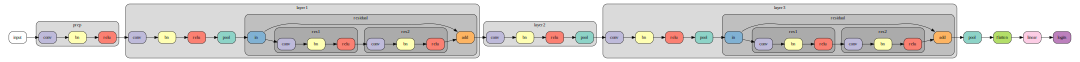

In [5]:
colors = ColorMap()
draw = lambda graph: DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None})

draw(build_graph(net()))

### Training

NB: on the first run, the first epoch will be slower as initialisation and Cudnn benchmarking take place.

In [6]:
epochs=24
lr_schedule = PiecewiseLinear([0, 5, epochs], [0, 0.4, 0])
batch_size = 512
train_transforms = [Crop(32, 32), FlipLR(), Cutout(8, 8)]
N_runs = 3

train_batches = DataLoader(Transform(train_set, train_transforms), batch_size, shuffle=True, set_random_choices=True, drop_last=True)
valid_batches = DataLoader(valid_set, batch_size, shuffle=False, drop_last=False)
lr = lambda step: lr_schedule(step/len(train_batches))/batch_size

summaries = []
for i in range(N_runs):
    print(f'Starting Run {i} at {localtime()}')
    model = Network(net()).to(device).half()
    opts = [SGD(trainable_params(model).values(), {'lr': lr, 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)})]
    logs, state = Table(), {MODEL: model, LOSS: x_ent_loss, OPTS: opts}
    for epoch in range(epochs):
        logs.append(union({'epoch': epoch+1}, train_epoch(state, Timer(torch.cuda.synchronize), train_batches, valid_batches)))
logs.df().query(f'epoch=={epochs}')[['train_acc', 'valid_acc']].describe()

Starting Run 0 at 2020-07-10 13:26:56
       epoch   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       6.0708       1.6451       0.4086       1.1962       1.5527       0.4384       6.0708
           2       6.4397       0.9469       0.6606       0.4630       0.8451       0.7067       6.4397
           3       6.4559       0.7288       0.7444       0.4552       0.8143       0.7286       6.4559
           4       6.4892       0.6332       0.7803       0.3594       0.6937       0.7590       6.4892
           5       4.1490       0.5606       0.8039       0.2180       0.9481       0.6717       4.1490
           6       6.6454       0.5010       0.8277       0.4661       0.7351       0.7564       6.6454
           7       6.4345       0.4443       0.8480       0.4597       0.4807       0.8335       6.4345
           8       6.4906       0.4137       0.8582       0.4915       0.6213       0.7955       6.4906
           9       4.6319 

,train_acc,valid_acc
count,1.000000,1.0000
mean,0.978677,0.9424
std,NaN,NaN
min,0.978677,0.9424
25%,0.978677,0.9424
50%,0.978677,0.9424
75%,0.978677,0.9424
max,0.978677,0.9424
